# Energy consumption in the Netherlands

In this Notebook, I will explore Energy and Gas Consumption in the Netherlands. The data is from the three largest Dutch energy and gas suppliers Enexis, Liander and Stedin. 

Every year, these network administrators release a table with energy consumption of the areas under their administration. 

The data is from the following websites:

Enexis: https://www.enexis.nl/over-ons/wat-bieden-we/andere-diensten/open-data
Liander: https://www.liander.nl/partners/datadiensten/open-data/data
Stedin: https://www.stedin.net/zakelijk/open-data/verbruiksgegevens



# Setting up the data analysis environment

First, I will import all packages that are needed for reading (i.e., processing), analyzing and vizualising the data. Well known packages are numpy, pandas, matplotlib and seaborn. 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns
import os


from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

In [3]:
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['legend.fontsize'] = 14

In [4]:
def load_and_reindex(path,filelist):
    start_time = datetime.now()
    df = None
    for file in filelist:
        year = file[-8:-4]
        manager = file.split('_')[0]
        if df is None:
            df = pd.read_csv(path+file)
            df['year'] = year
            df.index = manager+'_'+year+'_'+df.index.astype(str)
        else:
            temp = pd.read_csv(path+file)
            temp['year'] = year
            temp.index = manager+'_'+year+'_'+temp.index.astype(str)
            df = df.append(temp)
    # adding columns of interest
    df['low_tarif_consumption'] = df['annual_consume'].multiply(df['annual_consume_lowtarif_perc']/100)
    df['num_active_connections'] = df['num_connections'].multiply(df['perc_of_active_connections']/100).astype(int)
    try:
        df['num_smartmeters'] = df['num_connections'].multiply(df['smartmeter_perc']/100).astype(int)
    except ValueError:
        df['num_smartmeters'] = df['num_connections'].multiply(df['smartmeter_perc']/100)
        #print('Number of smartmeters could not be calculated')
    df['net_annual_consumption'] = df['annual_consume'].multiply(df['delivery_perc']/100)
    df['self_production'] = df['annual_consume'] - df['net_annual_consumption']
    df['self_prod_perc'] = df['self_production'].divide(df['annual_consume']/100)
    
    time_elapsed = datetime.now() - start_time
    print('Made main dataframe, time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))
    return(df)

In [5]:
path = 'C:\\Users/ss01/Desktop/Projects/dutch-energy/Electricity/'
files_all = [f for f in os.listdir(path)]
elec_all = load_and_reindex(path,files_all)

c:\users\ss01\appdata\local\programs\python\python35\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Made main dataframe, time elapsed (hh:mm:ss.ms) 0:00:31.889589


# Looking at the data

Now that we have set up the data analysis environment by importing the right packages, and have imported all data from our path, we print a list of all files in the directory. This is to make sure that all files in the directory have been read into a frame. 

We also print a list with all data to go through it. We get a gist of what variables are captured, how they are measured and if there are missing variables. 

In [90]:
#Please, uncomment to print lists -- I have commented them to save capacity in Jupyter Notebook
#print(files_all)
#print(elec_all)

# Total yearly energy consumption

In [9]:
# make pivot tables of relevant parameters such that we have total per city per year
annual_consume = pd.pivot_table(elec_all,values='annual_consume',index='city',columns='year',aggfunc=np.sum)
num_connections = pd.pivot_table(elec_all,values='num_connections',index='city',columns='year',aggfunc=np.sum)
num_active_connections = pd.pivot_table(elec_all,values='num_active_connections',index='city',columns='year',aggfunc=np.sum)
perc_active_connections = pd.pivot_table(elec_all,values='perc_of_active_connections',index='city',columns='year',aggfunc=np.mean)
smartmeter_perc = pd.pivot_table(elec_all,values='smartmeter_perc',index='city',columns='year',aggfunc=np.mean)
smartmeter_perc_median = pd.pivot_table(elec_all,values='smartmeter_perc',index='city',columns='year',aggfunc=np.median)
num_smartmeters = pd.pivot_table(elec_all,values='num_smartmeters',index='city',columns='year',aggfunc=np.sum)
self_production = pd.pivot_table(elec_all,values='self_production',index='city',columns='year',aggfunc=np.sum)
self_prod_perc_mean = pd.pivot_table(elec_all,values='self_prod_perc',index='city',columns='year',aggfunc=np.mean)
net_annu_consume = pd.pivot_table(elec_all,values='net_annual_consumption',index='city',columns='year',aggfunc=np.sum)
annu_cons_lowtarif_perc = pd.pivot_table(elec_all,values='annual_consume_lowtarif_perc',index='city',columns='year',aggfunc=np.mean)

Text(0.5, 1.0, 'Total yearly energy consumption')

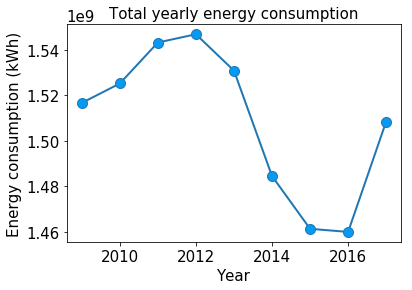

In [35]:
#print(annual_consume.sort_values('2018',ascending=False).head())
specs = {'markersize':10,'markerfacecolor':'xkcd:azure','linewidth':2}
plt.plot(annual_consume.columns.astype(int)-1,annual_consume.sum(),'-o',**specs)
#plt.yscale('log')
plt.ylabel('Energy consumption (kWh)')
plt.xlabel('Year')
plt.title('Total yearly energy consumption')


In [39]:
annual_consume.sum()/annual_consume.sum()[0]*100

year
2010    100.000000
2011    100.564821
2012    101.753046
2013    101.992985
2014    100.936282
2015     97.878383
2016     96.348463
2017     96.258342
2018     99.459732
dtype: float64

# Country-wide view

The following plot shows how electricity consumption in the Netherlands from 2010 to 2018. There is a focus on the total yearly consumption (net and gross), the total number of connections, the total of yearly self-produced energy (e.g. solar energy) and the total number of smart meters.

We see that the total number of connections has grown rapidly, as well as the total yearly self-produced energy. This trend started near 2012. The growth has even increased between 2016-2018, making solar energy more common in The Netherlands. 

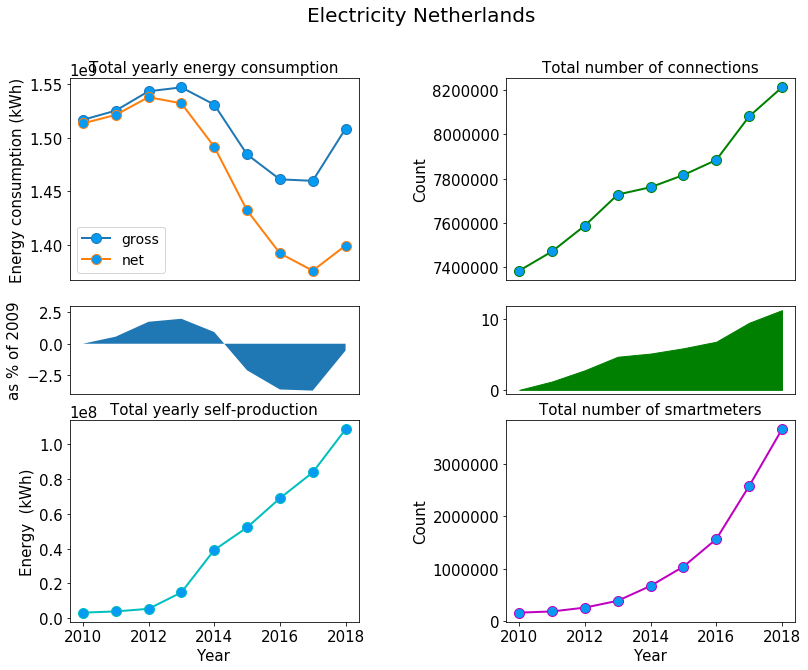

In [40]:
f = plt.figure()

gs = gridspec.GridSpec(5,2)
f.set_figwidth(13)
f.set_figheight(10)
plt.suptitle('Electricity Netherlands',fontsize=20)

ax1 = f.add_subplot(gs[0:2,0])
ax1.plot(annual_consume.columns.astype(int),annual_consume.sum(),'-o',**specs)
ax1.plot(annual_consume.columns.astype(int),net_annu_consume.sum(),'-o',**specs)
lgnd = plt.legend(['gross','net'])

#plt.yscale('log')
plt.ylabel('Energy consumption (kWh)')
plt.xlabel('');plt.xticks([])
plt.title('Total yearly energy consumption')

ax11 = f.add_subplot(gs[2,0])
ax11.fill_between(annual_consume.columns.astype(int),0,annual_consume.sum()/annual_consume.sum()[0]*100-100)#,'-o',**specs)
#plt.yscale('log')
plt.ylabel('as % of 2009')
plt.ylim(-4,3)
plt.xlabel('');plt.xticks([])
#plt.title('Total yearly energy consumption')

ax2 = f.add_subplot(gs[0:2,1])
ax2.plot(num_connections.columns.astype(int),num_connections.sum(),'-og',**specs)
#plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('');plt.xticks([])
plt.title('Total number of connections')

ax21 = f.add_subplot(gs[2,1])
ax21.fill_between(annual_consume.columns.astype(int),0,num_connections.sum()/num_connections.sum()[0]*100-100,color='g')#,'-o',**specs)
#plt.yscale('log')
#plt.ylabel('as % of 2008')
plt.xlabel('');plt.xticks([])
#plt.title('Total yearly energy consumption')

ax3 = f.add_subplot(gs[3:,0])
ax3.plot(self_production.columns.astype(int),self_production.sum(),'-oc',**specs)
#plt.yscale('log')
plt.ylabel('Energy  (kWh)')
plt.xlabel('Year')
plt.title('Total yearly self-production')

ax4 = f.add_subplot(gs[3:,1])
ax4.plot(num_smartmeters.columns.astype(int),num_smartmeters.sum(),'-om',**specs)
#plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Year')
plt.title('Total number of smartmeters')

gs.update(wspace=.51,hspace=.3)

The data shows that on average, less electricity is used per connection. We can draw this conclusion, since the yearly total energy consumption remains roughly the same between 2010-2018, but the number of connections is growing. 


# Smart meters 

It is interesting to zoom in on the smartmeters. I will compare the total number of smart meters with the total number of connections. 

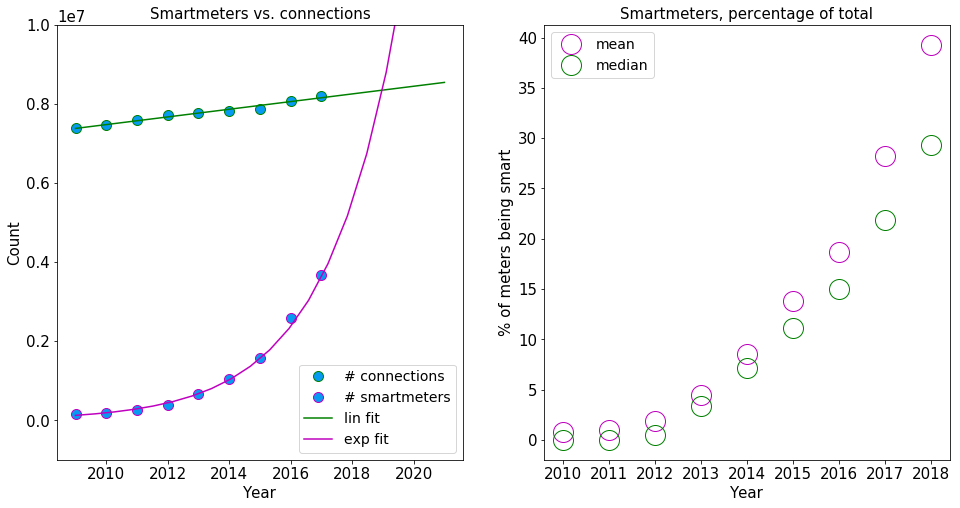

In [44]:
from scipy.optimize import curve_fit
x = num_smartmeters.columns.astype(int)-1
# exponential fit
def exponenial_func(x, a, b, c):
    return 1/(a*np.exp(-b*x)+c)
#p_opt, p_cov = curve_fit(exponenial_func, x, y, p0=(1e-16, 1e-6, ))
xfit = np.linspace(2009,2021,20)

me,be = np.polyfit(x,np.log(num_smartmeters.sum()),1)
# linear fit
m,b = np.polyfit(x,num_connections.sum(),1)

f,ax = plt.subplots(1,2,figsize=(16,8))

ax[0].plot(num_smartmeters.columns.astype(int)-1,num_connections.sum(),'og',**specs)
ax[0].plot(num_smartmeters.columns.astype(int)-1,num_smartmeters.sum(),'om',**specs)
ax[0].plot(xfit,m*xfit+b,'g')
ax[0].plot(xfit,np.exp(me*xfit+be),'m')

ax[0].set_ylabel('Count')
ax[0].set_xlabel('Year')
ax[0].legend(['# connections','# smartmeters','lin fit','exp fit'],loc=4)
ax[0].set_ylim(bottom=-1e6,top=1e7)
ax[0].set_title('Smartmeters vs. connections')

specs2 = {'markersize':20,'fillstyle':'none','linewidth':2}
# mean of the average per city:
ax[1].plot(num_smartmeters.columns.astype(int), smartmeter_perc.mean(),'om',**specs2)
# median of the average per city:
ax[1].plot(num_smartmeters.columns.astype(int), smartmeter_perc.median(),'og',**specs2)
ax[1].set_title('Smartmeters, percentage of total')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('% of meters being smart')
ax[1].legend(['mean','median'], fontsize=14)

It is noticeable that there is a difference in the mean and median of the distribution of smartmeters in cities. This means that the amount of smart meters is not normally distributed across cities in the Netherlands. 

# Electricity Production per City

In this section, I will zoom in on households that produce their own energy via solar panels. Prior data shows that producing energy is more common in the Netherlands since roughly 2012. 


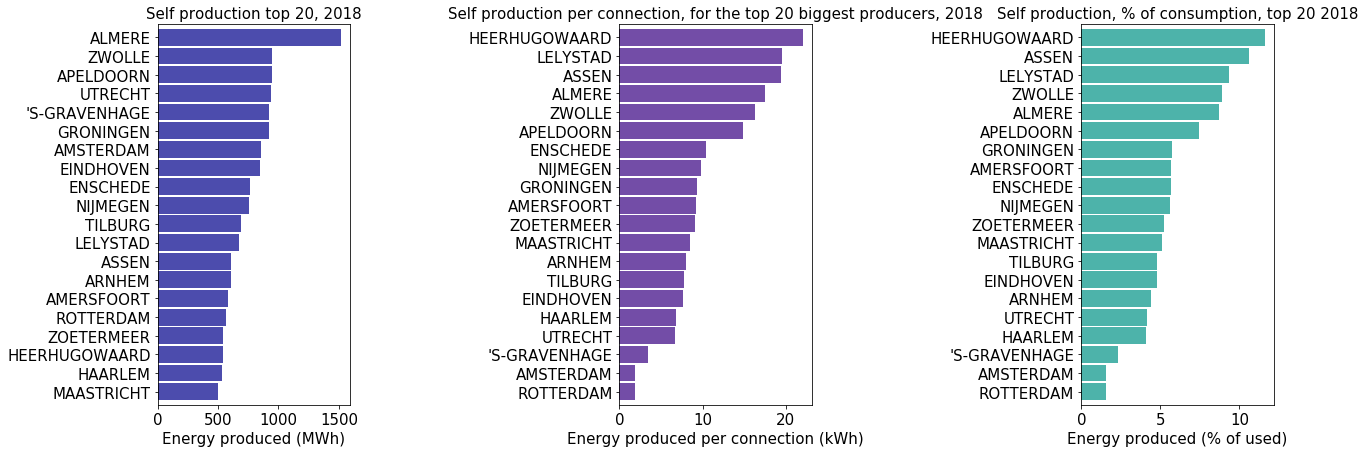

In [59]:
f = plt.figure()
gs = gridspec.GridSpec(1,5)

ax1 = f.add_subplot(gs[0,0])
elec_all[elec_all.year=='2018'].groupby('city').sum()['self_production'].divide(1e3).sort_values(ascending=False)[:20].plot.barh(color='darkblue',width=.9,alpha=.7,ax=ax1)
# could have achieved the same with self_production.sort_values('2018',ascending=False).divide(1e3)[:20]
plt.gca().invert_yaxis()
plt.xlabel('Energy produced (MWh)');plt.ylabel('')
plt.title('Self production top 20, 2018')

ax2 = f.add_subplot(gs[0,2])
self_production.divide(num_active_connections).loc[self_production.sort_values('2018',ascending=False).divide(1e3)[:20].index,:].sort_values('2018',ascending=False)['2018'].plot.barh(color='xkcd:indigo',width=.9,alpha=.7,ax=ax2)
plt.gca().invert_yaxis()
plt.xlabel('Energy produced per connection (kWh)');plt.ylabel('')
plt.title('Self production per connection, for the top 20 biggest producers, 2018')

ax3 = f.add_subplot(gs[0,4])
self_production.divide(annual_consume/100).loc[self_production.sort_values('2018',ascending=False).divide(1e3)[:20].index,:].sort_values('2018',ascending=False)['2018'].plot.barh(color='xkcd:teal',width=.9,alpha=.7,ax=ax3)
plt.gca().invert_yaxis()
plt.xlabel('Energy produced (% of used)');plt.ylabel('')
plt.title('Self production, % of consumption, top 20 2018')

f.set_figheight(7)
f.set_figwidth(20)

The graph shows that the Dutch city Almere is the biggest producer of solar energy in comparison to 20 cities in the Netherlands. Mainly the smaller cities are the largest producers.

When we emphasize on the 30 biggest energy producers in 2018, we see they are mostly small towns in the north-east. They have the highest average electricity production per household.

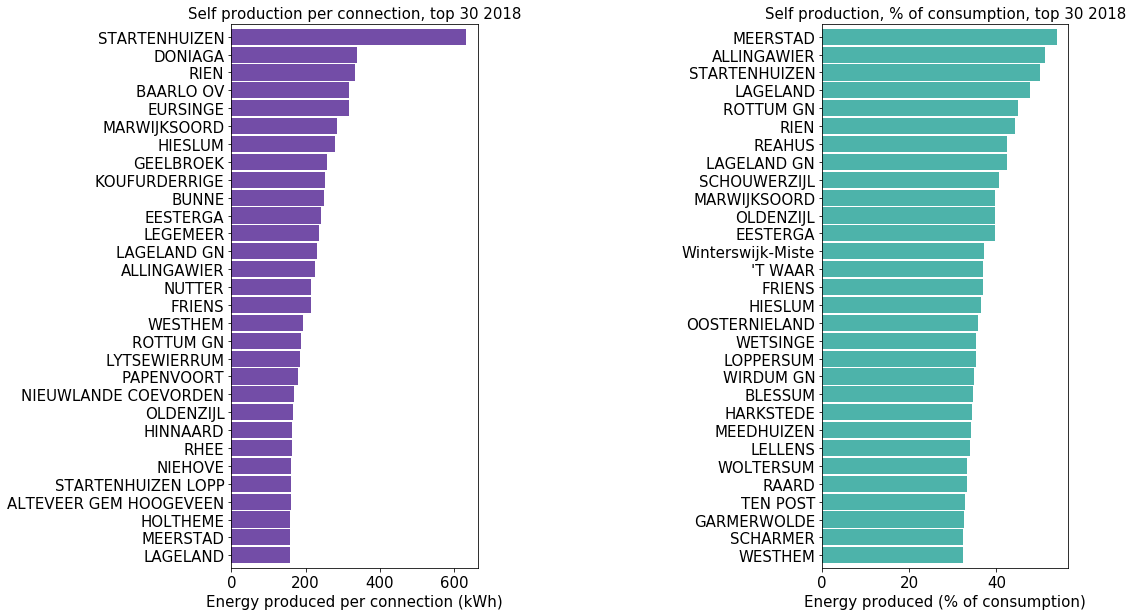

In [67]:
f = plt.figure()
gs = gridspec.GridSpec(1,3)

ax1 = f.add_subplot(gs[0,0])
self_production.divide(num_active_connections).sort_values('2018',ascending=False)['2018'][:30].plot.barh(color='xkcd:indigo',width=.9,alpha=.7,ax=ax1)
plt.gca().invert_yaxis()
plt.xlabel('Energy produced per connection (kWh)');plt.ylabel('')
plt.title('Self production per connection, top 30 2018')

ax2 = f.add_subplot(gs[0,2])
self_production.divide(annual_consume/100).sort_values('2018',ascending=False)['2018'][:30].plot.barh(color='xkcd:teal',width=.9,alpha=.7,ax=ax2)
plt.gca().invert_yaxis()
plt.xlabel('Energy produced (% of consumption)');plt.ylabel('')
plt.title('Self production, % of consumption, top 30 2018')

f.set_figheight(10)
f.set_figwidth(15)

Another interesting observation is to see how the self-production of energy has evolved per city from 2010-2018. 

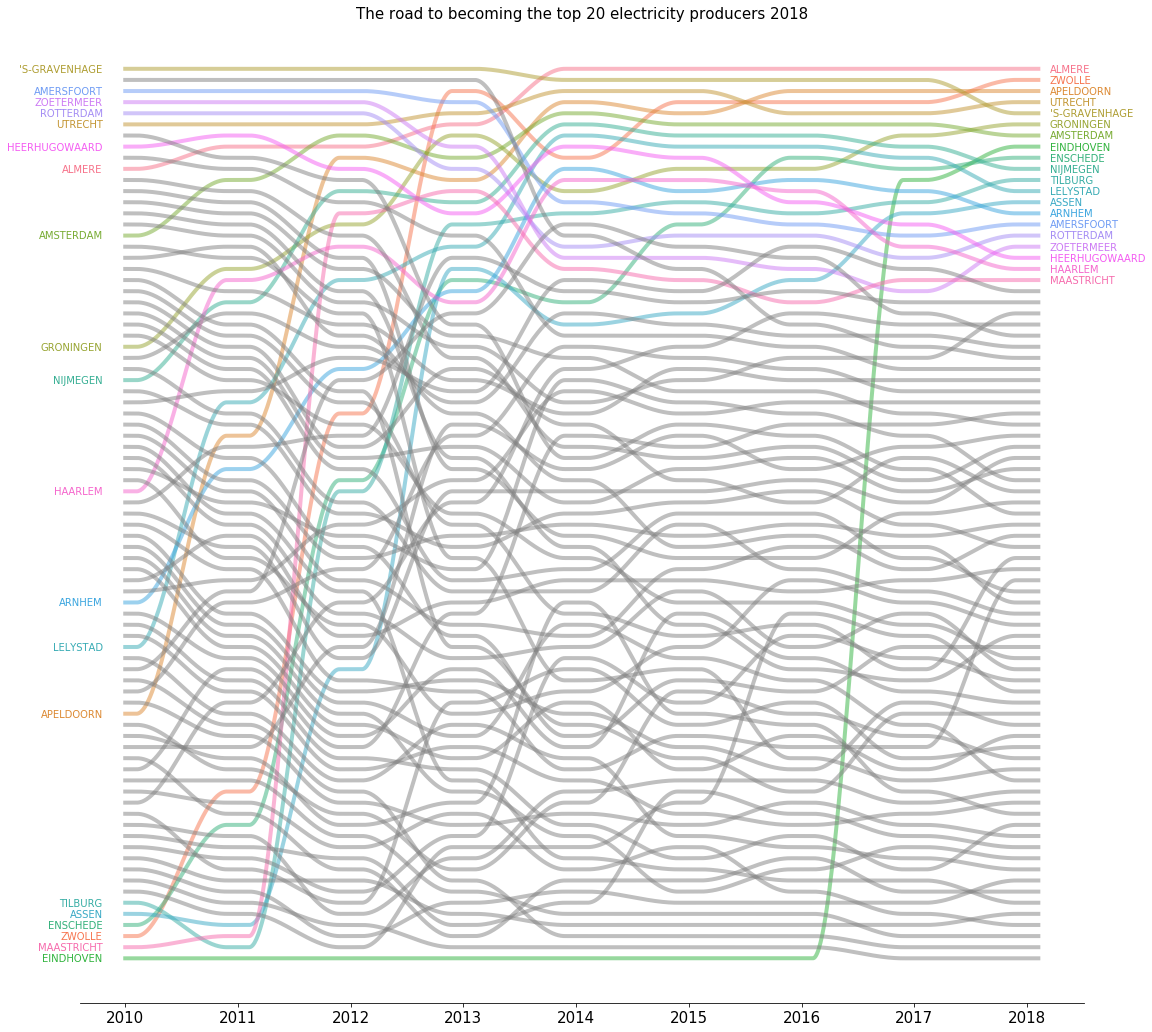

In [68]:
from collections import defaultdict
from scipy import interpolate


def streamgraph(dataframe, **kwargs):
    """ Wrapper around stackplot to make a streamgraph """
    X = dataframe.columns
    Xs = np.linspace(dataframe.columns[0], dataframe.columns[-1], num=1024)
    Ys = [interpolate.PchipInterpolator(X, y)(Xs) for y in dataframe.values]
    return plt.stackplot(Xs, Ys, labels=dataframe.index, **kwargs)

def add_widths(x, y, width=1):
    """ Adds flat parts to widths """
    new_x = []
    new_y = []
    for i,j in zip(x,y):
        new_x += [i-width, i, i+width]
        new_y += [j, j, j]
    return new_x, new_y

def bumpsplot(dataframe, color_dict=defaultdict(lambda: "k"), 
                         linewidth_dict=defaultdict(lambda: 4),
                         labels=[]):
    r = dataframe.rank(method="first")
    r = (r - r.max() + r.max().max()).fillna(0) # Sets NAs to 0 in rank
    for j in r.index:
        x = np.arange(r.shape[1])
        y = r.loc[j].values
        color = color_dict[j]
        lw = linewidth_dict[j]
        x, y = add_widths(x, y, width=0.1)
        xs = np.linspace(0, x[-1], num=1024)
        plt.plot(xs, interpolate.PchipInterpolator(x, y)(xs), color=color, linewidth=lw, alpha=0.5)
        if j in labels:
            plt.text(x[0] - 0.1, y[0], s=j, horizontalalignment="right", verticalalignment="center", color=color)
            plt.text(x[-1] + 0.1, y[-1], s=j, horizontalalignment="left", verticalalignment="center", color=color)
    plt.xticks(np.arange(r.shape[1]), dataframe.columns)
    
    
userank = self_production.sort_values('2010',ascending=False)
cities = list(userank[:75].index)
top_cities = list(self_production['2018'].sort_values(ascending=False).index[:20])
finallist = top_cities+list(set(cities).difference(set(top_cities)))
winter_colors = defaultdict(lambda: "grey")
lw = defaultdict(lambda: 1)

top_cities = list(self_production['2018'].sort_values(ascending=False).index[:20])
for i,c in enumerate(top_cities):
    winter_colors[c] = sns.color_palette("husl", n_colors=len(top_cities))[i]
    lw[c] = 4

f = plt.figure(figsize=(18,18))
bumpsplot(userank.loc[finallist,:],color_dict=winter_colors,labels=top_cities)
plt.gca().get_yaxis().set_visible(False)

#plt.gcf().subplots_adjust(left=0.25,bottom=.05,right=.75,top=.95)
sns.despine(left=True)  
plt.title('The road to becoming the top 20 electricity producers 2018')
plt.show()

From this graph, we could conclude that cities such as The Hague ('s Gravenhage), Amersfoort, Zoetermeer, Rotterdam and Utrecht stayed on top concerning electricity production. 

Other large cities such as Tilburg and Eindhoven underwent a large increase in 8 years time.

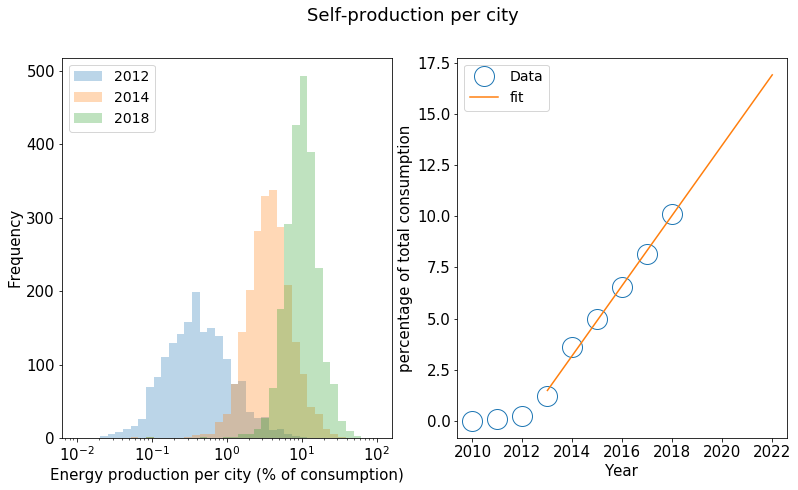

In [69]:
from matplotlib.ticker import MaxNLocator



f = plt.figure()
gs = gridspec.GridSpec(1,2)

ax1 = f.add_subplot(gs[0,0])
self_production.divide(annual_consume/100)['2012'].plot.hist(bins=np.logspace(-2,2,40),alpha=.3,ax=ax1)
self_production.divide(annual_consume/100)['2014'].plot.hist(bins=np.logspace(-2,2,40),alpha=.3,ax=ax1)
self_production.divide(annual_consume/100)['2018'].plot.hist(bins=np.logspace(-2,2,40),alpha=.3,ax=ax1)
#plt.axvline(self_production.divide(annual_consume/100)['2018'].median(),color='k')
plt.xscale('log')
plt.legend(['2012','2014','2018'])#,'2018 median'])
plt.xlabel('Energy production per city (% of consumption)')

ax2 = f.add_subplot(gs[0,1])
ax2.plot(list(range(2010,2019)),self_production.divide(annual_consume/100).median(),'o',**specs2)
xfit = list(range(2013,2019))
yfit = self_production.divide(annual_consume/100).median()[3:]
m,b = np.polyfit(xfit,yfit,1)
xpred = np.linspace(2013,2022,20)
ax2.plot(xpred,m*xpred+b)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel('percentage of total consumption')
plt.xlabel('Year')
plt.legend(['Data', 'fit'])
plt.suptitle('Self-production per city',fontsize=18)

f.set_figheight(7)
f.set_figwidth(13)

# Self produced energy per provider

The energy and gas supply is not competitive in the Netherlands. Each network administrator (Liander, Stedin or Enexis) serves a part of the Netherlands. 

In Amsterdam and surroundings, the network administrator is Liander, while in Rotterdam and surroundings Stedin is the electricity provider. In the east and north of the Netherlands Enexis is administrator.

Bij comparing self-produced energy per provider, we consequently tell more about self-produced energy per region. 

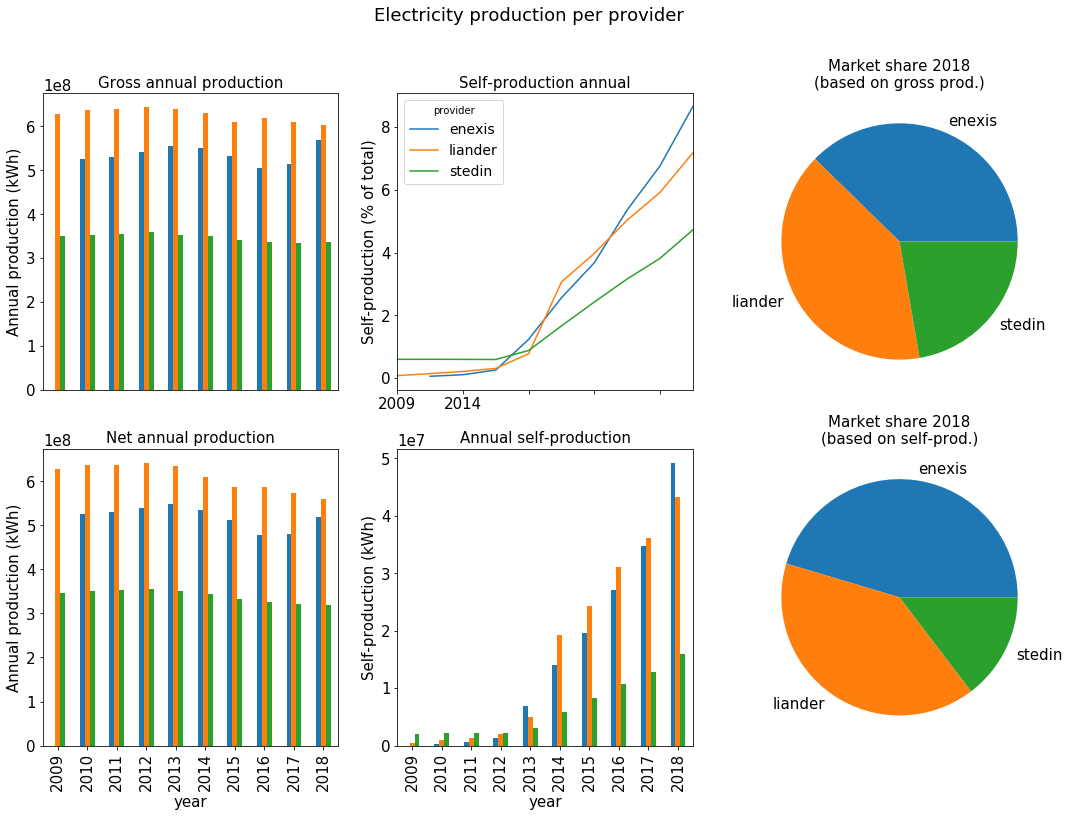

In [71]:
provider_self_prod = pd.pivot_table(elec_all,values='self_production',index='provider',columns='year',aggfunc=np.sum)
provider_prod = pd.pivot_table(elec_all,values='annual_consume',index='provider',columns='year',aggfunc=np.sum)
provider_net_prod = pd.pivot_table(elec_all,values='net_annual_consumption',index='provider',columns='year',aggfunc=np.sum)

f = plt.figure()
gs = gridspec.GridSpec(2,3)

ax1 = f.add_subplot(gs[0,0])
provider_prod.T.plot.bar(ax=ax1,legend=False)
#ax[0].set_yscale('log')
#ax[0].set_ylim(1e8,1e9)
ax1.set_ylabel('Annual production (kWh)')
ax1.set_title('Gross annual production')
ax1.set_xlabel('');ax1.set_xticks([])

ax2 = f.add_subplot(gs[0,1])
provider_self_prod.divide(provider_prod/100).T.plot(ax=ax2)
ax2.set_ylabel('Self-production (% of total)')
plt.suptitle('Electricity production per provider',fontsize=18)
ax2.set_title('Self-production annual')
ax2.set_xlabel('')

ax3 = f.add_subplot(gs[0,2])
provider_prod['2018'].plot.pie(ax=ax3)
ax3.set_title('Market share 2018\n(based on gross prod.)')
ax3.set_ylabel('')

ax4 = f.add_subplot(gs[1,0])
provider_net_prod.T.plot.bar(ax=ax4,legend=False)
#ax[0].set_yscale('log')
#ax[0].set_ylim(1e8,1e9)
ax4.set_ylabel('Annual production (kWh)')
ax4.set_title('Net annual production')

ax5 = f.add_subplot(gs[1,1])
provider_self_prod.T.plot.bar(ax=ax5,legend=False)
#ax[0].set_yscale('log')
#ax[0].set_ylim(1e8,1e9)
ax5.set_ylabel('Self-production (kWh)')
ax5.set_title('Annual self-production')

ax6 = f.add_subplot(gs[1,2])
provider_self_prod['2018'].plot.pie(ax=ax6)
ax6.set_title('Market share 2018\n(based on self-prod.)')
ax6.set_ylabel('')

f.set_figheight(12)
f.set_figwidth(18)

From the graphs above, we see that households in the Enexis regions are larger producers of electricity compared to the regions of Liander and Stedin. Most likely this is caused by more space in the eastern and northern part of the Netherlands, which allows more windmills and solar panels compared to the city environments (e.g. Amsterdam, Rotterdam and surroundings/ "Randstad*")

Disclaimer: The Randstad is a megalopolis in the central-western Netherlands consisting primarily of the four largest Dutch cities (Amsterdam, Rotterdam, The Hague and Utrecht) and their surrounding areas. 

# Does city size influence a city's self-production of electricity?

To examine if city size plays a role in the amount of self-produced electricity in a city, it is possible to statistically test the correlation between these two variables:


c:\users\ss01\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
c:\users\ss01\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


Text(0.5, 0.98, 'Self-production vs city size 2018')

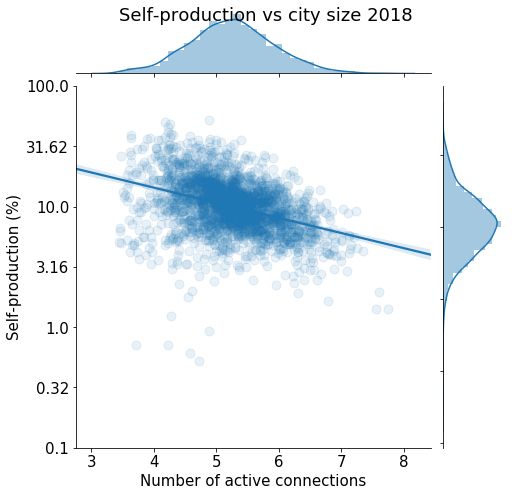

In [72]:
from scipy import stats

def make_log_df(x_data,y_data,year,offset):
    x = np.log10(x_data[year].dropna())
    y = np.log10(y_data[year].dropna())
    xfit = x.loc[y[y!=-np.inf].index]
    yfit = y[y!=-np.inf]
    # df for regression in log space
    data_for_reg = yfit.to_frame()
    data_for_reg.rename(index=str,columns={year:'y_'+year},inplace=True)
    data_for_reg = data_for_reg.join(xfit.to_frame())
    data_for_reg.rename(index=str,columns={year:'x_'+year},inplace=True)
    
    # set the cities with zero (-inf) to arbitrary dropout value
    y.loc[y[y==-np.inf].index] = -1
    # this includes dropout values intended not to be included in the regression,
    # but for plotting purposes only
    plot_data = y.to_frame().rename(index=str,columns={year:'y_'+year})
    plot_data = plot_data.join(x.to_frame().rename(index=str,columns={year:'x_'+year}))
    data_for_reg,fitparams = classify(data_for_reg,offset,year)
    return(data_for_reg,plot_data,fitparams) 

def classify(df,offset,year):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['x_'+year],df['y_'+year])
    df['offset_'+year] = df['y_'+year] - (df['x_'+year]*slope+intercept)
    df['cat_'+year] = ['over' if f>offset else 'under' if f<-offset else 'in' for f in df['offset_'+year]]
    fit = [slope, intercept, r_value, p_value, std_err]
    return(df,fit)
    
y1 = np.log10(self_prod_perc_mean['2018'].dropna())
x1 = np.log10(annual_consume['2018'].dropna())
regdata,pldata,fit = make_log_df(annual_consume,self_prod_perc_mean,'2018',.15) 
#plt.scatter(x1,y1,alpha=.2)
sns.jointplot('x_2018','y_2018',data=regdata,kind='reg',scatter_kws={'alpha':0.1,'s':80},height=7)
plt.ylabel('Self-production (%)')
plt.xlabel('Number of active connections')
loc,label = plt.yticks()
yticks = [round(10**float(f),2) for f in loc]
plt.yticks(loc,yticks)
plt.suptitle('Self-production vs city size 2018')

From above correlation analysis, we see that there is a negative correlation between city size and self-produced energy. This means that larger cities are less likely to produce energy, for example with solar panes and wind mills.

# City size and self-production 

Now that we have seen that there is a negative correlation between city size and the percentage of self-produced energy, it is interesting to see how this relationship has evolved over a larger period of time:

c:\users\ss01\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
c:\users\ss01\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


Text(0.5, 0.98, 'City size vs. self-production percentage')

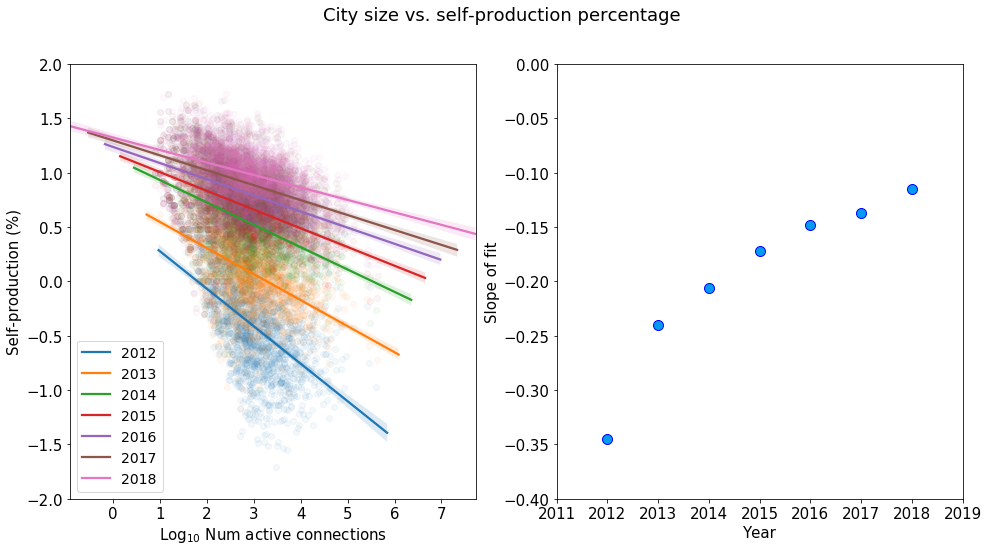

In [73]:
f,ax = plt.subplots(1,2,figsize=(16,8))
leg = [];slope_evol = [];offset = []
for i in range(2012,2019):
    y=str(i)
    regdata,plotdata,fit = make_log_df(num_active_connections,self_prod_perc_mean,y,.15)
    leg.append(y)
    sns.regplot('x_'+y,'y_'+y,regdata,x_ci='ci',scatter=True,scatter_kws={'alpha':0.05},ax=ax[0])
    slope_evol.append(fit[0])
    offset.append(fit[1])
    ax[0].set_ylim(-2,2) # 0.01 to 100%
    ax[0].legend(leg)
    ax[0].set_ylabel('Self-production (%)')
    ax[0].set_xlabel('Log$_{10}$ Num active connections')

"""    abel = [round(10**(item.get_position()[]),2) for item in ax[0].get_yticklabels()]
    ax[0].set_yticklabels(abel)

    ax[0].set_yticklabels(abel)
"""
ax[1].plot(range(2012,2019),slope_evol,'ob',**specs)
ax[1].set_xlim(2011,2019)
ax[1].set_ylim(-.4,0)
ax[1].set_ylabel('Slope of fit')
ax[1].set_xlabel('Year')
plt.suptitle('City size vs. self-production percentage')

When we compare the negative relationship from 2012 to 2018, the slope has decreased. This means that self-production has increased over time.

# Dutch cities and self-production

It is useful to classify Dutch cities into 'overperforming' and 'underperforming' in terms of self-producing electricity. This can be done using linear regression:

c:\users\ss01\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
c:\users\ss01\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
c:\users\ss01\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
c:\users\ss01\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
c:\users\ss01\appdata\local\programs\python\python35\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs

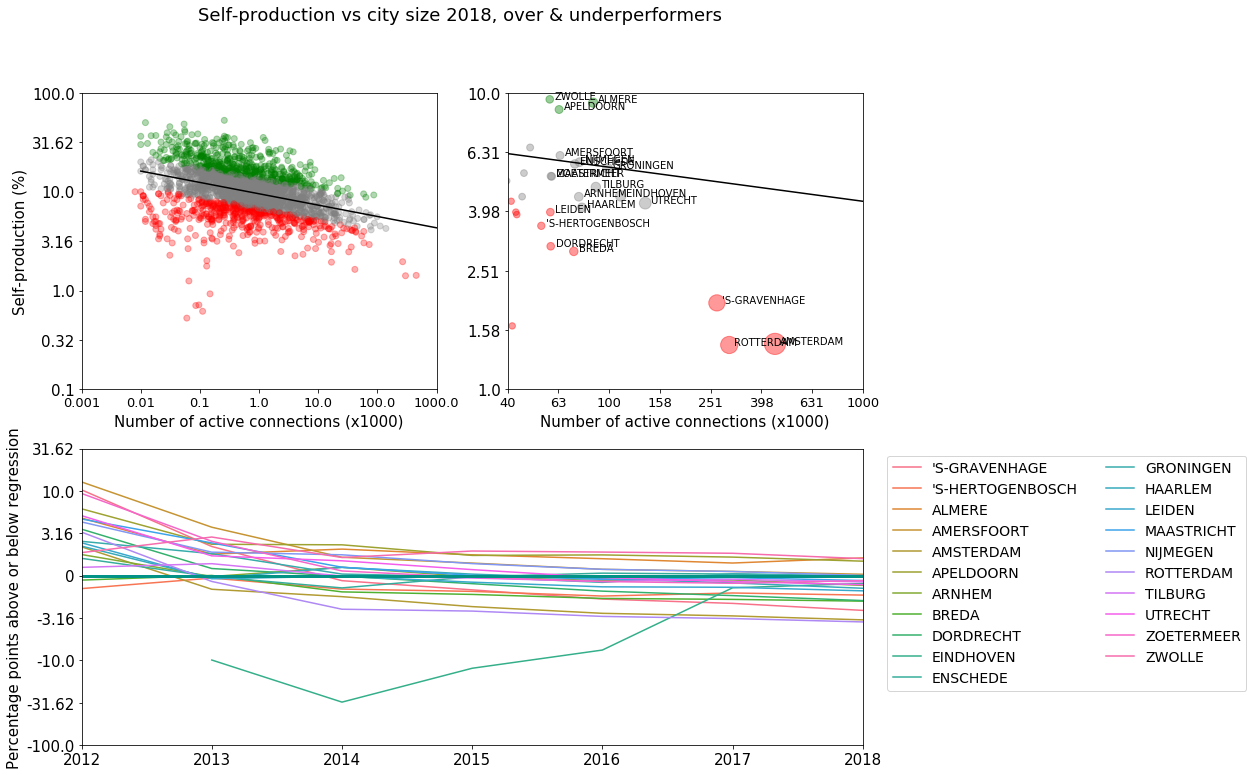

In [74]:
regdata,plotdata,fit = make_log_df(num_active_connections,self_prod_perc_mean,'2018',.15)
lut = {'in':[.5,.5,.5],'over':'g','under':'r'}
color = regdata['cat_2018'].map(lut)

f = plt.figure(figsize=(14,12))
gs = gridspec.GridSpec(2,2)
xregr = np.linspace(1,6,10)
#slope, intercept, r_value, p_value, std_err = stats.linregress(regdata['x'],regdata['y'])
#plt.plot(num_active_connections['2015'],self_prod_perc_mean['2015'],'o',ms=10,alpha=.2)
ax1 = f.add_subplot(gs[0,0])
#sns.regplot('x','y',regdata,x_ci='ci',scatter=False,scatter_kws={'alpha':0.1,'s':75})#,ax=ax)
#sns.jointplot('x','y',data=data,kind='reg')
plt.scatter(regdata['x_2018'],regdata['y_2018'],alpha=.31,color=color)
#plt.plot(x,y,'o',ms=10,alpha=.1,color=[.5,.5,.5])
plt.plot(xregr,fit[0]*xregr+fit[1],'k')
#plt.plot(xregr,slope*xregr+intercept+.15,'.-k')
#plt.plot(xregr,slope*xregr+intercept-.15,'.-k')
#plt.xscale('log');plt.yscale('log')
plt.ylabel('Self-production (%)')
plt.xlabel('Number of active connections (x1000)')
plt.ylim(-1,2)
loc,label = plt.yticks()
yticks = [round(10**float(f),2) for f in loc]
plt.yticks(loc,yticks)
loc,label = plt.xticks()
xticks = [round((10**float(f))/1e3,3) for f in loc]
plt.xticks(loc,xticks,fontsize=13)
#plt.text(2.5,-.5,"$y=$"+str(round(slope,3))+"$x+$"+str(round(10**intercept,3)),fontsize=15)
#plt.grid()
plt.xlim(0,6)
#plt.axvline(np.log10(5e4))

ax2 = f.add_subplot(gs[0,1])
ax2.scatter(regdata['x_2018'],regdata['y_2018'],s=num_active_connections.loc[regdata.index,'2018']/1e3,alpha=.4,color=color)
#plt.plot(x,y,'o',ms=10,alpha=.1,color=[.5,.5,.5])
ax2.plot(xregr,fit[0]*xregr+fit[1],'k')
#plt.ylabel('Self-production (%)')
plt.xlabel('Number of active connections (x1000)')
plt.ylim(0,1.)
plt.xlim(left=np.log10(4e4),right=6)
loc,label = plt.yticks()
yticks = [round(10**float(f),2) for f in loc]
plt.yticks(loc,yticks)
loc,label = plt.xticks()
xticks = [round((10**float(f))/1e3) for f in loc]
plt.xticks(loc,xticks,fontsize=13)
twenty18 = num_active_connections['2018'].to_frame()
twenty18_L = twenty18[twenty18>5e4].dropna()
for cit in twenty18_L.index:
    x = regdata.loc[cit,'x_2018']
    y = regdata.loc[cit,'y_2018']
    plt.text(x+.02,y,cit)
    
plt.suptitle('Self-production vs city size 2018, over & underperformers')
all_offset = pd.DataFrame(index=twenty18_L.index,columns=[0])
for year in range(2012,2019):
    year = str(year)
    regdata,plotdata,fit = make_log_df(num_active_connections,self_prod_perc_mean,year,.15)
    if year=='2012':
        all_offset = regdata.loc[twenty18_L.index,:]
    else:
        all_offset = all_offset.join(regdata.loc[twenty18_L.index,:])
ax3 = f.add_subplot(gs[1,:])
values = sns.color_palette('husl',len(all_offset));keys = all_offset.index
lut = dict(zip(keys,values))
colors = all_offset.index.map(lut)
all_offset.loc[:,['offset_2012','offset_2013','offset_2014','offset_2015','offset_2016','offset_2017','offset_2018']].T.plot(ax=ax3,color=colors)
plt.axhline(0,color='xkcd:teal',linewidth=3)
loc,label = plt.xticks()
plt.ylabel('Percentage points above or below regression')
plt.xticks(loc,[int(f+2012) for f in loc])

loc,label = plt.yticks()
yticks = [round(10**float(abs(f)),2) if f>0 else -round(10**float(abs(f)),2) if f<0 else 0 for f in loc]
plt.yticks(loc,yticks)
plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right', ncol=2)

From above graph we can conclude that the large cities are keeping behind in electricity production. This is most likely caused because they cannot keep up with the rapid growth in self-production of smaller cities. Because of this most large cities are "underperforming".

Dutch cities that seem to be doing a pretty good job are Almere, Apeldoorn and Zwolle. 


# Conclusion

* In The Netherlands, there are three electricity providers, Liander, Enexis and Stedin. 
* Liander supplies electricity in the region Amsterdam and surroundings, Stedin is network administrator for Rotterdam and surroundings and Enexis has east and north of the Netherlands. 
* Total electricity consumption has remained constant over the past years.
* The number of connections is growing. This means that the electricity consumption per connection is decreasing. The same amount of electricity is now distributed among more connections.
* Households in the Netherlands are increasingly producing their own electricity.
* The region of Enexis produces most electricity. This is most likely because Enexis operates in smaller and rural areas, where windmills and solar panels are more common than in densed cities (i.e. Randstad) where Liander and Stedin operate.
